# Comparison of BPC, GPC, and LQR on Linear Dynamical Systems

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import numpy as onp
import jax.random as random
import tigercontrol
from tigercontrol.utils.random import set_key, generate_key
from tigercontrol.environments import Environment
from tigercontrol.controllers import Controller
from jax import grad,jit

/Users/paulag/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
set_key(0) # make everything deterministic

In [3]:
from controllers.bpc import BPC
from controllers.gpc import GPC
from controllers.lqr import LQR
from environments.lds import LDS

In [4]:
def get_regret(T, model, x):
    loss = onp.zeros(T)
    avg_regret = onp.zeros(T)
    c_t = 0 # cost of initial function is 0
    for i in range(T):
        u = model.get_action()
        c_t = loss_fn(x, u)
        x = problem.step(u)
        model.update(c_t, x)
        loss[i] = c_t
        avg_regret[i] = avg_regret[-1] * i / (i+1) + c_t /(i+1)
    return loss, avg_regret

# Sanity Check

For the LDS system, the matrices A, B are generated randomly. The cost function used is c(x, u) = ||x||2 + ||u||2 . The baseline is designed with the pre-fixed matrix K set to 0. In all figures, we plot the averaged results for a fixed random system determined by A, B, for each setting, over 20 experiment runs.

In [5]:
noise_distribution = 'normal'

(a) d = 1

In [6]:
n = 1 # dimension of  the state x 
m = 1 # control dimension
T = 200 # number of timesteps

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [7]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)

BPC_loss, BPC_avg_regret = get_regret(T, bpc, x)

In [8]:
K = np.zeros((m, n))
H, HH = 8, 16

x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
gpc = GPC()
gpc.initialize(problem.A, problem.B, H, HH, K, x)

GPC_loss, GPC_avg_regret = get_regret(T, gpc, x)

In [9]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
lqr.initialize(problem.A, problem.B, n, m, x, Q, R)

LQR_loss, LQR_avg_regret = get_regret(T, lqr, x)

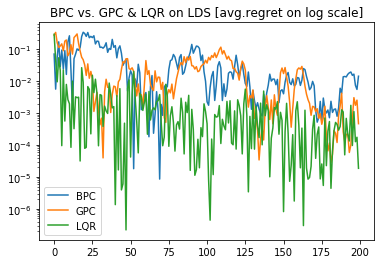

In [13]:
plt.plot(BPC_avg_regret, label = "BPC")
plt.plot(GPC_avg_regret, label = "GPC")
plt.plot(LQR_avg_regret, label = "LQR")
plt.yscale('log')
plt.title("BPC vs. GPC & LQR on LDS [avg.regret on log scale]");
plt.legend();

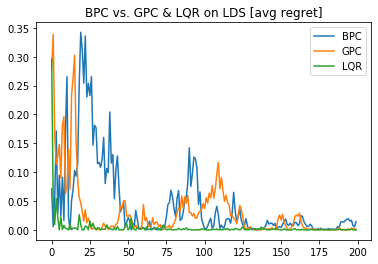

In [14]:
plt.plot(BPC_avg_regret, label = "BPC")
plt.plot(GPC_avg_regret, label = "GPC")
plt.plot(LQR_avg_regret, label = "LQR")
#plt.yscale('log')
plt.title("BPC vs. GPC & LQR on LDS [avg regret]");
plt.legend();

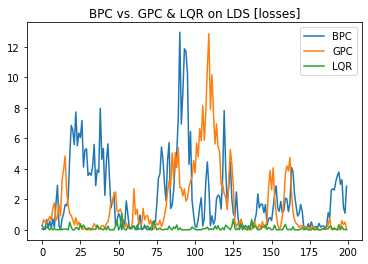

In [16]:
plt.plot(BPC_loss, label = "BPC")
plt.plot(GPC_loss, label = "GPC")
plt.plot(LQR_loss, label = "LQR")
plt.title("BPC vs. GPC & LQR on LDS [losses]");
plt.legend();

(b) d = 10

In [18]:
n = 10 # dimension of  the state x 
m = 10 # control dimension
T = 200 # number of timesteps

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [19]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)

BPC_loss, BPC_avg_regret = get_regret(T, bpc, x)

In [20]:
K = np.zeros((m, n))
H, HH = 8, 16

x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
gpc = GPC()
gpc.initialize(problem.A, problem.B, H, HH, K, x)

GPC_loss, GPC_avg_regret = get_regret(T, gpc, x)

In [21]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
lqr.initialize(problem.A, problem.B, n, m, x, Q, R)

LQR_loss, LQR_avg_regret = get_regret(T, lqr, x)

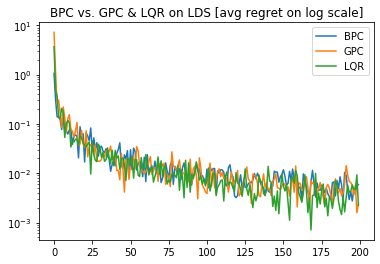

In [25]:
plt.plot(BPC_avg_regret, label = "BPC")
plt.plot(GPC_avg_regret, label = "GPC")
plt.plot(LQR_avg_regret, label = "LQR")
plt.yscale('log')
plt.title("BPC vs. GPC & LQR on LDS [avg regret on log scale]");
plt.legend();

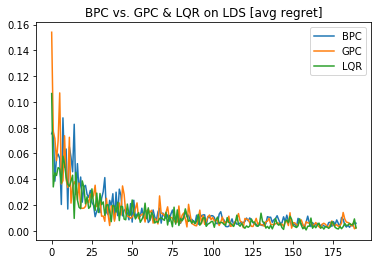

In [26]:
plt.plot(BPC_avg_regret[10:], label = "BPC")
plt.plot(GPC_avg_regret[10:], label = "GPC")
plt.plot(LQR_avg_regret[10:], label = "LQR")
plt.title("BPC vs. GPC & LQR on LDS [avg regret]");
plt.legend();

(c) d = 100

In [27]:
n = 100 # dimension of  the state x 
m = 100 # control dimension
T = 500 # number of timesteps

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [28]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)

BPC_loss, BPC_avg_regret = get_regret(T, bpc, x)

In [29]:
K = np.zeros((m, n))
H, HH = 8, 16

x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
gpc = GPC()
gpc.initialize(problem.A, problem.B, H, HH, K, x)

GPC_loss, GPC_avg_regret = get_regret(T, gpc, x)

In [30]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
lqr.initialize(problem.A, problem.B, n, m, x, Q, R)

LQR_loss, LQR_avg_regret = get_regret(T, lqr, x)

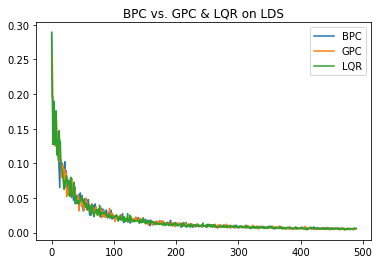

In [32]:
plt.plot(BPC_avg_regret[10:], label = "BPC")
plt.plot(GPC_avg_regret[10:], label = "GPC")
plt.plot(LQR_avg_regret[10:], label = "LQR")
plt.title("BPC vs. GPC & LQR on LDS");
plt.legend();

# Correlated noise experiment

## Gaussian Random Walk

In the first setting, the noise terms are $w_{t+1} ∼ N(w_t,0.3^2)$, and are then clipped to the range [−1, 1].

In [71]:
noise_magnitude = 0.3

In [72]:
def get_next_w(n, x, u, w, t):
    next_w = w + noise_magnitude * random.normal(generate_key(), shape = (n,))
    next_w = np.minimum(np.ones(n), next_w)
    next_w = np.maximum(-np.ones(n), next_w)
    print(next_w)
    return next_w

In [73]:
## PROBLEM ##
n = 10 # dimension of  the state x 
m = 10 # control dimension

problem = LDS()
x = problem.initialize(n, m, noise_distribution = get_next_w)

Q = 0.5 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [74]:
## BPC ##
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)

BPC_loss, BPC_avg_regret = get_regret(T, bpc, x)

In [68]:
K = np.zeros((m, n))
H, HH = 8, 16

x = problem.initialize(n, m, noise_distribution = get_next_w)
gpc = GPC()
gpc.initialize(problem.A, problem.B, H, HH, K, x)

GPC_loss, GPC_avg_regret = get_regret(T, gpc, x)

In [75]:
## LQR ##
x = problem.initialize(n, m, noise_distribution = get_next_w)
lqr = LQR()
lqr.initialize(problem.A, problem.B, n, m, x, Q, R)

LQR_loss, LQR_avg_regret = get_regret(T, lqr, x)

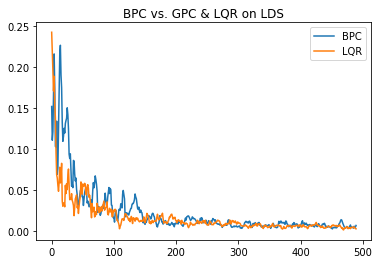

In [76]:
plt.plot(BPC_avg_regret[10:], label = "BPC")
#plt.plot(GPC_avg_regret, label = "GPC")
plt.plot(LQR_avg_regret[10:], label = "LQR")
plt.title("BPC vs. GPC & LQR on LDS");
plt.legend();

## Sine Noise

In [77]:
noise_magnitude = 0.3

In [78]:
def get_next_w(n, x, u, w, t):
    return noise_magnitude * np.sin(t)

In [79]:
## PROBLEM ##
n = 1 # dimension of  the state x 
m = 1 # control dimension

problem = LDS()
x = problem.initialize(n, m, noise_distribution = get_next_w)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [80]:
## BPC ##
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)

BPC_loss, BPC_avg_regret = get_regret(T, bpc, x)

In [44]:
K = np.zeros((m, n))
H, HH = 8, 16

x = problem.initialize(n, m, noise_distribution = get_next_w)
gpc = GPC()
gpc.initialize(problem.A, problem.B, H, HH, K, x)

GPC_loss, GPC_avg_regret = get_regret(T, gpc, x)

In [81]:
## LQR ##
x = problem.initialize(n, m, noise_distribution = get_next_w)
lqr = LQR()
lqr.initialize(problem.A, problem.B, n, m, x, Q, R)

LQR_loss, LQR_avg_regret = get_regret(T, lqr, x)

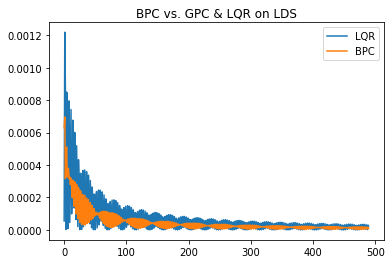

In [88]:
#plt.plot(GPC_avg_regret, label = "GPC")
plt.plot(LQR_avg_regret[10:], label = "LQR")
plt.plot(BPC_avg_regret[10:], label = "BPC")
plt.title("BPC vs. GPC & LQR on LDS");
plt.legend();